Models to train : 
Logistic Regression ,
Decision Tree into Random Forest,
Linear Regression

Analytics to note:
Confusion Matrix(For Later),
Accuracy,
Accuracy scores for different hyper parameter configurations

Visualisations:
Accuracy vs Iteration graph,
Roc_auc_scores,

TSNE to check for seperability
PCA to improve training times

In [1]:
# import dask_cudf as cdf
import cudf
import io, requests
from cuml.preprocessing import StandardScaler
from cuml.linear_model import LogisticRegression
from cuml.multiclass import MulticlassClassifier
from cuml.ensemble import RandomForestClassifier as cuRFC  
from cuml.metrics.accuracy import accuracy_score
from cuml.metrics import confusion_matrix
# import cuml
# from dask.distributed import Client, progress, wait
# import dask_cudf
import numpy as np
# import cudf
# from cuml.dask.ensemble import RandomForestClassifier as cumlDaskRF
# from cuml.dask.common import utils as dask_utils

In [2]:
# import matplotlib.pyplot as plt
# import seaborn as sn
# import numpy as np
import math
# import random
import scipy
import pandas as pd
import seaborn as sns
# import numpy as np
# import seaborn as sns
# import sklearn.manifold
# from math import floor
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.linear_model import LogisticRegression

In [3]:
train_set = cudf.read_csv('learning2.csv')


In [4]:
train_set_1 = train_set[train_set['date']>'2014-12-31']
del train_set

In [5]:
train_set=train_set_1.drop(columns=['Unnamed: 0.1','Unnamed: 0', 'fips', 'date','aspectUnknown','CULT_LAND'])

print(train_set.shape)
# now columns not required for now are removed
#train first model
del train_set_1

(323232, 48)


<AxesSubplot: >

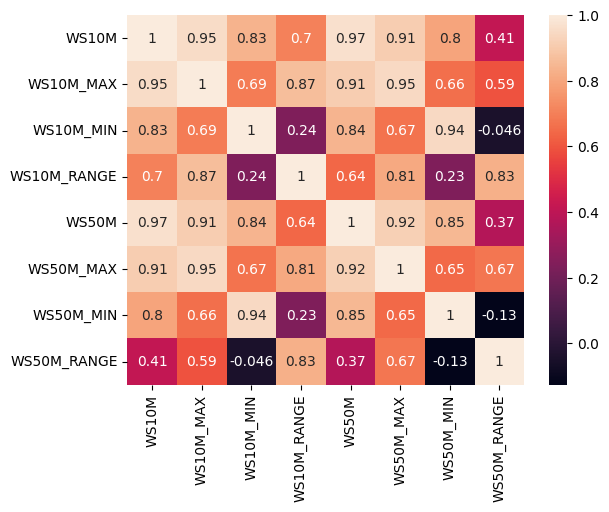

In [59]:
sns.heatmap(data=train_set[['WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']].corr(),annot=True)

In [6]:
train_set['score']= np.floor(train_set['score'])
y_train = train_set['score']
print(y_train.shape)
train_set_1=train_set.drop(columns=['score'])


(323232,)


In [7]:
del train_set

In [ ]:
for i in range(len(train_set.columns)):
    print(i,train_set.columns[i])

In [8]:
scaler = StandardScaler()
scaler.fit(train_set_1)
normalized_train_set = scaler.transform(train_set_1)

In [9]:
print(normalized_train_set.columns)

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46],
           dtype='int64')


In [10]:
normalized_train_set = normalized_train_set.drop(columns=[4,5,6,7,11,12,14,15,16,17,20,24,25,26,27,28,37,41,43,44,45,46])


In [11]:
print(normalized_train_set.shape)
# del train_set_1

(323232, 25)


In [ ]:
test_set = cudf.read_csv('modelvalidation.csv')
test_set=test_set.drop(columns=['Unnamed: 0.1', 'Unnamed: 0','fips', 'date','aspectUnknown','CULT_LAND'])


In [9]:
normalized_test_set = scaler.transform(test_set)

In [11]:
del test_set
!nvidia-smi

NameError: name 'test_set' is not defined

In [15]:
test_set_1 = normalized_test_set.drop(columns=[4,5,6,7,11,12,14,15,16,17,20,24,25,26,27,28,37,41,43,44,45,46])


In [17]:
del normalized_test_set
!nvidia-smi

NameError: name 'normalized_test_set' is not defined

In [12]:
y_train.value_counts()

0.0    240431
1.0     47640
2.0     18914
3.0      9331
4.0      4982
5.0      1934
Name: score, dtype: int32

In [24]:
cuml_model = cuRFC(max_features=1.0,n_estimators=100,n_bins=256,max_depth=20,split_criterion='entropy',max_samples=0.80)
cuml_model.fit(train_set_1,y_train.score)

/root/miniconda3/envs/rapids-22.10/lib/python3.9/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


RandomForestClassifier()

In [26]:
pred= cuml_model.predict(X=test_set_1,predict_model='CPU')
# pred= cuml_model.predict(train_set_1)

In [27]:
print(accuracy_score(y_test,pred))
pred.value_counts()

0.729983389377594


0.0    304024
1.0      8317
2.0      6030
3.0      3419
4.0      1194
5.0       248
dtype: int32

In [20]:

del pred


NameError: name 'cuml_model' is not defined

In [ ]:
# since models are taking too long to trian and aren't that accurate we start removing features 

In [23]:
print(train_set_1.shape)

(2756796, 25)


In [24]:
from cuml.linear_model import LogisticRegression
from cuml.multiclass import MulticlassClassifier
weights= {0:0,1:1,2:1,3:1,4:1,5:1}
cls = MulticlassClassifier(LogisticRegression(penalty='l2',tol=1e-6,class_weight='balanced',max_iter=1000), strategy='ovr')
cls.fit(train_set_1,y_train)

MulticlassClassifier()

In [30]:
pred=cls.predict(test_set_1)
accuracy_score(y_test,pred)

0.7445116639137268

In [31]:
pred.value_counts()


0.0    318238
2.0      2604
3.0      1568
1.0       813
4.0         9
dtype: int32

In [26]:
del pred

NameError: name 'cls' is not defined

In [18]:
normalized_train_set.shape

(323232, 25)

In [29]:
from cuml import PCA
pca = PCA(n_components = 4)
train_set_2 = pca.fit_transform(train_set_normal)


In [15]:
SVM_losses=[]

In [ ]:
from cuml.svm import SVC
# from cuml.multiclass import MulticlassClassifier
# C=1.0,kernel='poly',degree=3,class_weight='balanced',multiclass_strategy='ovr',max_iter=1000
SVM = SVC(C=1.0,kernel='rbf',degree=3,class_weight='balanced',multiclass_strategy='ovr',max_iter=2000,cache_size=512,tol=1e-2)
SVM.fit(normalized_train_set,y_train)

In [ ]:
pred = SVM.predict(test_set_1)
accuracy_score(y_test,pred)

In [ ]:
pred.value_counts()

In [ ]:
del SVM